In [1]:
import warnings
from typing import Dict, Optional, List

import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import (
    StratifiedKFold,
    train_test_split,
    cross_validate,
)
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.covariance import OAS

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    f1_score,
    matthews_corrcoef,
    confusion_matrix,
    average_precision_score,
)

from scipy.stats import chi2

In [2]:
GENE = "BRCA1"
SEED = 42

In [3]:
data = pd.read_csv("data/global/bio/BRCA1/classified_BRCA1_3356_bio.txt", sep="\t", na_values=["999", "999.0", 999, 999.0])
leb_data  = pd.read_csv("data/local/BRCA1/bio/classified_BRCA1_953_bio.txt",  sep="\t", na_values=["999", "999.0", 999, 999.0])
vus = pd.read_csv("data/local/BRCA1/bio/vus_BRCA1_2_bio.txt", sep="\t", na_values=["999", "999.0", 999, 999.0])

if GENE == "BRCA2":
    data = pd.read_csv("data/global/bio/BRCA2/classified_BRCA2_4115_bio.txt", sep="\t", na_values=["999", "999.0", 999, 999.0])
    leb_data  = pd.read_csv("data/local/BRCA2/bio/classified_BRCA2_682_bio.txt",  sep="\t", na_values=["999", "999.0", 999, 999.0])
    vus = pd.read_csv("data/local/BRCA2/bio/vus_BRCA2_10_bio.txt", sep="\t", na_values=["999", "999.0", 999, 999.0])

# uncomment for ablation results
# to_drop = ["Consequence_severity"]
to_drop = []
features = ["Variant_length", "bStatistic",  "phyloP17way_primate", "Exon_number", "hydrophobicity_delta", "charge_change", "polarity_change", "aromatic_change",  "ti_tv", "Consequence_severity"]

features = [x for x in features if x not in to_drop]   


leb_test = leb_data[features].copy()
leb_label = leb_data["label"]

X = data[features]
y = data["label"]
vus_test = vus[features].copy()

X_benign = leb_data[leb_data["label"] == 0]
X_pathogenic = leb_data[leb_data["label"] == 1]

X_benign = X_benign[features]
X_pathogenic = X_pathogenic[features]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=SEED)

In [4]:
X_train.replace("999", np.nan, inplace=True)
X_test.replace("999", np.nan, inplace=True)
vus_test.replace("999", np.nan, inplace=True)
X_benign.replace("999", np.nan, inplace=True)
X_pathogenic.replace("999", np.nan, inplace=True)
leb_test.replace("999", np.nan, inplace=True)

In [5]:
print(f"Selected Features: {len(X_train.columns)}")

Selected Features: 10


label
0     889
1    1795
Name: count, dtype: int64


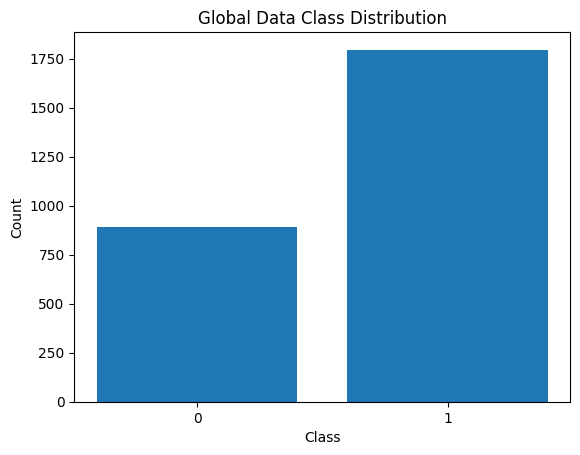

In [6]:
class_counts = y_train.value_counts().sort_index()
print(class_counts)

plt.bar(class_counts.index, class_counts.values)
plt.xticks([0, 1])
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Global Data Class Distribution")
plt.show()

### Training

In [7]:
class CorrelationFilter(BaseEstimator, TransformerMixin):
    # we drop one of any pair of features whose abs(corr) > threshold
    def __init__(self, threshold=0.98):
        self.threshold = threshold

    def fit(self, X, y=None):
        df = pd.DataFrame(X)
        corr = df.corr().abs()
        upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
        self.to_drop_ = [i for i in range(upper.shape[1]) 
                         if (upper.iloc[:, i] > self.threshold).any()]
        return self

    def transform(self, X):
        return np.delete(X, self.to_drop_, axis=1)

In [8]:
class DropAllNaNColumns(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        self.keep_cols_ = X.columns[~X.isna().all(axis=0)]
        return self
    def transform(self, X):
        X = pd.DataFrame(X)
        return X[self.keep_cols_]

In [9]:
def _resolved_feature_names_after_preproc(preproc, X, feature_names=None):
	if feature_names is not None:
		names = list(feature_names)
	elif hasattr(X, "columns"):
		names = list(X.columns)
	else:
		names = [f"f{i}" for i in range(X.shape[1])]

	drop_nan = preproc.named_steps.get("drop_all_nan", None)
	if drop_nan is not None and hasattr(drop_nan, "keep_cols_"):
		keep_cols = drop_nan.keep_cols_
		if hasattr(X, "columns") and all(isinstance(c, str) for c in keep_cols):
			names = [n for n in names if n in keep_cols]
		else:
			names = [names[i] for i in keep_cols]

	imputer = preproc.named_steps.get("imputer", None)
	if imputer is not None and getattr(imputer, "add_indicator", False):
		ind = getattr(imputer, "indicator_", None)
		if ind is not None and hasattr(ind, "features_"):
			ind_idx = list(ind.features_)
			indicator_names = [f"{names[j]}__missing" for j in ind_idx]
			names = names + indicator_names

	vt = preproc.named_steps.get("var_thresh", None)
	if vt is not None and hasattr(vt, "get_support"):
		keep_idx_vt = vt.get_support(indices=True)
		names = [names[i] for i in keep_idx_vt]

	cf = preproc.named_steps.get("corr_filter", None)
	if cf is not None and hasattr(cf, "to_drop_"):
		to_drop = set(cf.to_drop_)
		names = [n for i, n in enumerate(names) if i not in to_drop]

	return names


def _print_logistic_importance(clf, final_names, top_k=10, title_prefix="Logistic"):
	coefs = clf.coef_.ravel()
	order = np.argsort(np.abs(coefs))[::-1][:top_k]
	rows = []
	
	for i in order:
		sign = "+" if coefs[i] >= 0 else "-"
		rows.append((final_names[i], float(coefs[i]), sign))
		
	print(f"\n[{title_prefix}] Top {top_k} features by |coef| (with sign):")
	
	for name, coef, sign in rows:
		print(f"  {name:<30s} {sign}{abs(coef):.4f}")


def _print_tree_importance(clf, final_names, top_k=10, title_prefix="Tree"):
	if hasattr(clf, "feature_importances_"):
		imps = clf.feature_importances_
		order = np.argsort(imps)[::-1][:top_k]
		print(f"\n[{title_prefix}] Top {top_k} features by impurity importance:")
		for i in order:
			print(f"  {final_names[i]:<30s} {imps[i]:.6f}")


def _xgb_shap_importance(clf, X_trans, final_names, top_k=10):
	explainer = shap.TreeExplainer(clf)
	shap_vals = explainer.shap_values(X_trans)

	if isinstance(shap_vals, list):
		shap_vals = shap_vals[0]

	mean_abs = np.mean(np.abs(shap_vals), axis=0)
	order = np.argsort(mean_abs)[::-1][:top_k]
	rows = [(final_names[i], float(mean_abs[i])) for i in order]
	return rows

In [10]:
def cross_validate_models(
	pipelines: Dict[str, object],
	X_train: np.ndarray, y_train: np.ndarray,
	X_test: np.ndarray, y_test: np.ndarray,
	vus_test: Optional[np.ndarray] = None,
	feature_names: Optional[List[str]] = None,
	n_folds: int = 5,
	random_state: int = 0,
	n_jobs: int = -1
):

	scoring = {
		"accuracy": "accuracy",
		"mcc": "matthews_corrcoef",
		"roc_auc": "roc_auc",
		"precision": "precision",
		"recall": "recall",
		"f1": "f1",
	}

	kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_state)

	for name, pipe in pipelines.items():
		print("\n" + "=" * 80)
		print(f"{name.upper()} — Stratified {n_folds}-fold CV")

		cv_results = cross_validate(
			pipe, X_train, y_train,
			cv=kf,
			scoring=scoring,
			return_train_score=True,
			n_jobs=n_jobs,
			error_score="raise"
		)

		def _m(metric):
			return np.mean(cv_results[f"test_{metric}"]), np.std(cv_results[f"test_{metric}"])

		def _mtr(metric):
			return np.mean(cv_results[f"train_{metric}"]), np.std(cv_results[f"train_{metric}"])

		print(" Train:")
		for m in ["accuracy", "mcc", "roc_auc", "precision", "recall", "f1"]:
			mean_, std_ = _mtr(m)
			print(f"  {m:<10s} {mean_:.4f} ± {std_:.4f}")

		print(" Valid:")
		for m in ["accuracy", "mcc", "roc_auc", "precision", "recall", "f1"]:
			mean_, std_ = _m(m)
			print(f"  {m:<10s} {mean_:.4f} ± {std_:.4f}")

		pipe_fit = clone(pipe)
		pipe_fit.fit(X_train, y_train)

		y_pred = pipe_fit.predict(X_test)
		if hasattr(pipe_fit, "predict_proba"):
			y_prob = pipe_fit.predict_proba(X_test)[:, 1]
			auc = roc_auc_score(y_test, y_prob)
		else:
			y_prob = None
			auc = np.nan

		test_metrics = {
			"precision": precision_score(y_test, y_pred, zero_division=0),
			"recall": recall_score(y_test, y_pred, zero_division=0),
			"f1": f1_score(y_test, y_pred, zero_division=0),
			"accuracy": accuracy_score(y_test, y_pred),
			"roc_auc": auc,
			"mcc": matthews_corrcoef(y_test, y_pred),
		}
		print("\n Test (held‑out):")
		for k, v in test_metrics.items():
			print(f"  {k:<10s} {v:.4f}")

		# test model on leb_data
		y_leb_pred = pipe_fit.predict(leb_test)
		if hasattr(pipe_fit, "predict_proba"):
			y_leb_proba = pipe_fit.predict_proba(leb_test)[:, 1]
			auc_leb = roc_auc_score(leb_label, y_leb_proba)
		else:
			y_leb_proba = None
			auc_leb = np.nan

		test_leb_metrics = {
			"precision": precision_score(leb_label, y_leb_pred, zero_division=0),
			"recall": recall_score(leb_label, y_leb_pred, zero_division=0),
			"f1": f1_score(leb_label, y_leb_pred, zero_division=0),
			"accuracy": accuracy_score(leb_label, y_leb_pred),
			"roc_auc": auc_leb,
			"mcc": matthews_corrcoef(leb_label, y_leb_pred),
		}
  
		print("\n Test (Lebanese Data):")
		for k, v in test_leb_metrics.items():
			print(f"  {k:<10s} {v:.4f}")

		# this allows me to test models without preprocessing to see difference
		if "preproc" in pipe_fit.named_steps:
			preproc = pipe_fit.named_steps["preproc"]
			final_names = _resolved_feature_names_after_preproc(preproc, X_train, feature_names)
			Xtr_trans = preproc.transform(X_train)
		else:
			# no preproc step
			final_names = feature_names or [f"f{i}" for i in range(X_train.shape[1])]
			Xtr_trans = X_train

		clf = pipe_fit.named_steps.get("clf")

		if isinstance(clf, LogisticRegression):
			_print_logistic_importance(clf, final_names, top_k=10, title_prefix="LogisticRegression")

		if isinstance(clf, XGBClassifier):
			rows = _xgb_shap_importance(clf, Xtr_trans, final_names, top_k=10)
			print("\n[XGBoost] Top 10 features by mean |SHAP|:")
			for name_i, val in rows:
				print(f"  {name_i:<30s} {val:.6f}")

		if isinstance(clf, DecisionTreeClassifier):
			_print_tree_importance(clf, final_names, top_k=10, title_prefix="DecisionTree")

		if vus_test is not None:
			try:
				vus_preds = pipe_fit.predict(vus_test)
				if hasattr(pipe_fit, "predict_proba"):
					vus_probs = pipe_fit.predict_proba(vus_test)[:, 1]
				else:
					vus_probs = None
				print("\n VUS predictions:", vus_preds)
				if vus_probs is not None:
					print(" VUS probabilities:", vus_probs)
			except Exception as e:
				print(f"\n VUS inference failed for {name}: {e}")

In [11]:


preprocessor = Pipeline([
	("drop_all_nan", DropAllNaNColumns()),
    ("imputer", SimpleImputer(strategy="median", add_indicator=True)),
    ("var_thresh", VarianceThreshold(threshold=1e-5)),
    ("corr_filter", CorrelationFilter(threshold=0.98)),
    ("scaler", RobustScaler(quantile_range=(25,75)))
])

In [12]:
preprocessor_xgb = Pipeline([
	("drop_all_nan", DropAllNaNColumns()),
    ("imputer", SimpleImputer(fill_value=np.nan)),
    ("var_thresh", VarianceThreshold(threshold=1e-5)),
    ("corr_filter", CorrelationFilter(threshold=0.98)),
    ("scaler", StandardScaler()),
])

In [13]:
pipelines = {
    "xgboost": Pipeline([
        ("preproc", preprocessor_xgb),
        
        ("clf", XGBClassifier(
			booster="gbtree",
			objective="binary:logistic",
			learning_rate=0.3,
			max_depth=3,
			min_child_weight=1,
			subsample=1,
			colsample_bytree=1,
			n_estimators=100,
			eval_metric="logloss",
			random_state = SEED
        )),
    ]),
    "logistic_lbfgs": Pipeline([
		("preproc", preprocessor),
		("clf", LogisticRegression(
			penalty="l2",
			solver="lbfgs",
			class_weight="balanced",
			C=1.0,
			max_iter=750,
			random_state=SEED
		)),
	]),
    "decision_tree": Pipeline([
		("preproc", preprocessor),
		("clf", DecisionTreeClassifier(
				criterion="gini",
				max_depth=3,
				class_weight="balanced",
				min_samples_split=40,
				min_samples_leaf=20,
				random_state=SEED
			)),
	])
}

In [14]:
X_processed = preprocessor.fit_transform(X_train)
features_after_preproc = _resolved_feature_names_after_preproc(preprocessor, X_train, features)
print(f"Feature names after preprocessing: {features_after_preproc}")
print(f"Number of features after preprocessing : {len(features_after_preproc)}")

Feature names after preprocessing: ['Variant_length', 'bStatistic', 'phyloP17way_primate', 'Exon_number', 'hydrophobicity_delta', 'charge_change', 'polarity_change', 'aromatic_change', 'ti_tv', 'Consequence_severity', 'bStatistic__missing', 'Exon_number__missing', 'hydrophobicity_delta__missing', 'ti_tv__missing', 'Consequence_severity__missing']
Number of features after preprocessing : 15


In [15]:
cross_validate_models(
    pipelines=pipelines,
    X_train=X_train, y_train=y_train,
    X_test=X_test, y_test=y_test,
    vus_test=vus_test,
    feature_names=features,
    n_folds=5,
    random_state=SEED,
)



XGBOOST — Stratified 5-fold CV
 Train:
  accuracy   0.9956 ± 0.0006
  mcc        0.9901 ± 0.0014
  roc_auc    0.9994 ± 0.0003
  precision  0.9969 ± 0.0011
  recall     0.9965 ± 0.0009
  f1         0.9967 ± 0.0005
 Valid:
  accuracy   0.9870 ± 0.0031
  mcc        0.9707 ± 0.0070
  roc_auc    0.9981 ± 0.0020
  precision  0.9911 ± 0.0058
  recall     0.9894 ± 0.0064
  f1         0.9902 ± 0.0023

 Test (held‑out):
  precision  1.0000
  recall     0.9933
  f1         0.9967
  accuracy   0.9955
  roc_auc    0.9995
  mcc        0.9900

 Test (Lebanese Data):
  precision  1.0000
  recall     1.0000
  f1         1.0000
  accuracy   1.0000
  roc_auc    1.0000
  mcc        1.0000

[XGBoost] Top 10 features by mean |SHAP|:
  Consequence_severity           5.994174
  Exon_number                    0.952592
  Variant_length                 0.457983
  phyloP17way_primate            0.388614
  ti_tv                          0.285194
  bStatistic                     0.163826
  hydrophobicity_delta    

In [16]:
print(f"Num pathogenic: {len(X_pathogenic)}")
print(f"Num benign train: {len(X_benign)}")

Num pathogenic: 8
Num benign train: 945


In [17]:
X_train_benign, X_test_benign = train_test_split(
    X_benign, test_size=0.1, random_state=42, shuffle=True
)

Threshold (train-only): 8.056  |  alpha=0.995
Specificity: 1.000 | Recall: 1.000
Accuracy: 1.000 | F1: 1.000
AUROC: 1.000 | AUPRC: 1.000

Number of misclassified benign variants (false positives): 0/95


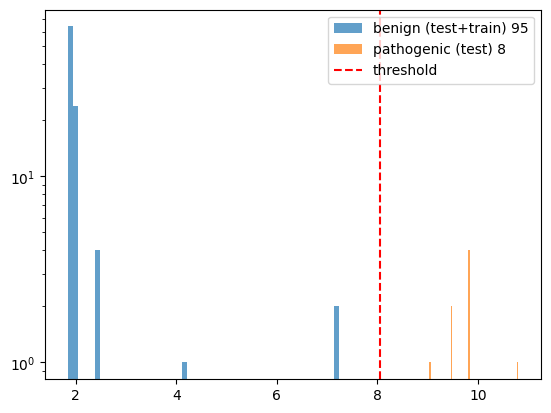


[Chi-square p-values for pathogenic test entries]
Degrees of freedom (k): 8
Count p<0.05: 8/8 | p<0.01: 8/8

Index	Mahalanobis_d	p_value(chi2_sf)
0	9.4696		5.415e-16
1	10.8023		1.598e-21
2	9.8322		2.041e-17
3	9.0270		2.453e-14
4	9.4696		5.415e-16
5	9.8322		2.041e-17
6	9.8322		2.041e-17
7	9.8322		2.041e-17


In [18]:
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

X_test_pathogenic = X_pathogenic.copy()

warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

Ztr = preprocessor.fit_transform(X_train_benign)
Ztb = preprocessor.transform(X_test_benign)
Ztp = preprocessor.transform(X_pathogenic)

oas = OAS().fit(Ztr)
mu, Prec = oas.location_, oas.precision_

# Mahalanobis distances
d_tr = ((Ztr - mu) @ Prec * (Ztr - mu)).sum(1)**0.5
d_tb = ((Ztb - mu) @ Prec * (Ztb - mu)).sum(1)**0.5
d_tp = ((Ztp - mu) @ Prec * (Ztp - mu)).sum(1)**0.5

alpha = 0.995  # target benign specificity 99.5%
train_threshold = np.percentile(d_tr, 100*alpha)              # empirical
theory_threshold = (chi2.ppf(alpha, df=Ztr.shape[1]))**0.5    # theoretical chi squared cutoff
threshold = train_threshold
# threshold = theory_threshold

y_scores = np.concatenate([d_tb, d_tp])
y_true   = np.concatenate([np.zeros(len(d_tb)), np.ones(len(d_tp))])
y_pred   = (y_scores > threshold).astype(int)

tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

print(f"Threshold (train-only): {threshold:.3f}  |  alpha={alpha}")
print(f"Specificity: {tn/(tn+fp):.3f} | Recall: {tp/(tp+fn):.3f}")
print(f"Accuracy: {accuracy_score(y_true, y_pred):.3f} | F1: {f1_score(y_true, y_pred):.3f}")
print(f"AUROC: {roc_auc_score(y_true, y_scores):.3f} | AUPRC: {average_precision_score(y_true, y_scores):.3f}")

print(f"\nNumber of misclassified benign variants (false positives): {fp}/{len(d_tb)}")

plt.hist(d_tb, bins=50, alpha=0.7, label=f"benign (test+train) {len(d_tb)}")
plt.hist(d_tp, bins=50, alpha=0.7, label=f"pathogenic (test) {len(d_tp)}")
plt.axvline(threshold, color='red', linestyle='--', label='threshold')
plt.yscale("log"); plt.legend(); plt.show()

k = Ztr.shape[1]
pvals_tp = chi2.sf(d_tp**2, df=k)
n05 = int(np.sum(pvals_tp < 0.05)); n01 = int(np.sum(pvals_tp < 0.01))
print("\n[Chi-square p-values for pathogenic test entries]")
print(f"Degrees of freedom (k): {k}")
print(f"Count p<0.05: {n05}/{len(pvals_tp)} | p<0.01: {n01}/{len(pvals_tp)}")
print("\nIndex\tMahalanobis_d\tp_value(chi2_sf)")
for i, (d_i, p_i) in enumerate(zip(d_tp, pvals_tp)):
    print(f"{i}\t{d_i:.4f}\t\t{p_i:.3e}")


## Anomaly Detection Inference on Lebanese VUS

In [19]:
X_vus_scaled = preprocessor.transform(vus_test)

mahal_scores_vus  = ((X_vus_scaled - mu) @ Prec * (X_vus_scaled - mu)).sum(1) ** 0.5

anomalous_flags = np.array(mahal_scores_vus) > train_threshold
k = Ztr.shape[1]
pvals_tp = chi2.sf(mahal_scores_vus**2, df=k)  # survival function = 1 - CDF

vus_results = pd.DataFrame({
    "Mahalanobis_score": mahal_scores_vus,
    "Predicted_anomaly": anomalous_flags,
    "p_values(chi2_sf)": pvals_tp
})

print(vus_results.sort_values("Mahalanobis_score", ascending=False).head(10))

   Mahalanobis_score  Predicted_anomaly  p_values(chi2_sf)
0           7.621891              False       1.101351e-09
1           3.885842              False       5.723428e-02


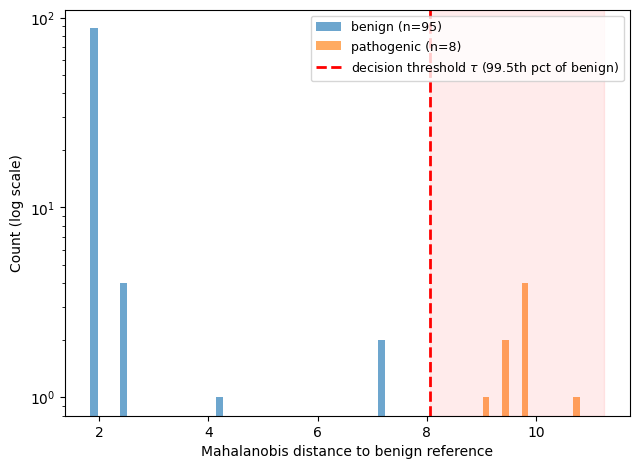

In [20]:
LEGEND_OUTSIDE = False
INCLUDE_THRESHOLD_IN_LEGEND = True
SHADE_ANOMALY_REGION = True
DPI = 300

benign_mahal = sorted(d_tb)
mahal_scores = sorted(d_tp)

max_val = max(max(benign_mahal), max(mahal_scores)) * 1.02
bins = np.linspace(0, max_val, 50)

fig, ax = plt.subplots(figsize=(6.5, 4.8))

ax.hist(benign_mahal, bins=40, alpha=0.65, label=f"benign (n={len(benign_mahal)})")
ax.hist(mahal_scores, bins=15, alpha=0.65, label=f"pathogenic (n={len(mahal_scores)})")

line_label = r'decision threshold $\tau$ (99.5th pct of benign)' if INCLUDE_THRESHOLD_IN_LEGEND else None
ax.axvline(train_threshold, color='red', linestyle='--', linewidth=2, label=line_label)

if not INCLUDE_THRESHOLD_IN_LEGEND:
    ax.text(train_threshold, 0.95, r'$\tau$ (99.5th pct of benign)',
            rotation=0, va='center', ha='left', transform=ax.get_xaxis_transform())

if SHADE_ANOMALY_REGION:
    ax.axvspan(train_threshold, ax.get_xlim()[1], color='red', alpha=0.08)

ax.set_yscale("log")
ax.set_xlabel("Mahalanobis distance to benign reference")
ax.set_ylabel("Count (log scale)")

handles, labels = ax.get_legend_handles_labels()
if LEGEND_OUTSIDE:
    ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.02, 1.0),
              borderaxespad=0., frameon=True, fontsize=9)
else:
    ax.legend(handles, labels, loc='upper right', frameon=True, fontsize=9)

plt.tight_layout()


plt.show()
